In [1]:
!pip install ipython-sql sqlalchemy prettytable==3.9.0 faker


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 25.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 22.4 MB/s eta 0:00:00
  Attempting uninstall: prettytable
    Found existing installation: prettytable 3.17.0
    Uninstalling prettytable-3.17.0:
      Successfully uninstalled prettytable-3.17.0


In [2]:
%load_ext sql

In [3]:
%sql sqlite:///claims.db

In [5]:
import pandas as pd
import numpy as np
from faker import Faker

fake = Faker()
np.random.seed(42)

n = 10000

emirates = ["Dubai", "Abu Dhabi", "Sharjah", "Ajman", "RAK", "Fujairah", "UAQ"]
claim_types = ["Medical", "Dental", "Pharmacy", "Emergency", "Surgery"]
providers = ["Aster", "Mediclinic", "NMC", "King's College", "American Hospital", "Saudi German", "Prime Hospital"]

rejection_reasons = [
    "Missing Documents",
    "Policy Expired",
    "Non-covered Service",
    "Incorrect Coding",
    "Duplicate Claim",
    "Exceeded Policy Limit",
    None
]

data = {
    "claim_id": [fake.uuid4() for _ in range(n)],
    "claim_date": [fake.date_between(start_date="-1y", end_date="today") for _ in range(n)],
    "customer_age": np.random.randint(18, 80, n),
    "emirate": np.random.choice(emirates, n),
    "claim_amount": np.round(np.random.uniform(50, 20000, n), 2),
    "claim_type": np.random.choice(claim_types, n),
    "provider": np.random.choice(providers, n),
    "approval_status": np.random.choice(["Approved", "Rejected"], n, p=[0.72, 0.28]),
}

# reject reasons only for rejected
data["rejection_reason"] = [
    np.random.choice(rejection_reasons[:-1]) if status == "Rejected" else None
    for status in data["approval_status"]
]

# messy processing times with outliers 90–200
processing_times = np.random.normal(7, 3, n).clip(1, 60)
processing_times[np.random.randint(0, n, 50)] = np.random.randint(90, 200, 50)
data["processing_time_days"] = processing_times

df = pd.DataFrame(data)

df.head()


,claim_id,claim_date,customer_age,emirate,claim_amount,claim_type,provider,approval_status,rejection_reason,processing_time_days
0,54cacaba-5bb0-4c1f-9202-67f56e98b131,2025-06-28,56,Ajman,7776.46,Medical,Mediclinic,Approved,None,4.950321
1,b2e2241f-02cd-43fd-bd9f-14c2e04b883c,2025-02-01,69,Abu Dhabi,12024.04,Emergency,Aster,Approved,None,8.305010
2,5dd9160e-8a2c-4920-9190-4f4ee381217a,2025-11-18,46,RAK,10297.37,Dental,Mediclinic,Approved,None,11.876021
3,413d060a-ab94-4a06-b7a2-d8363afba27b,2025-11-02,32,RAK,13906.11,Surgery,Aster,Approved,None,175.000000
4,9e996e24-78a9-4d07-a66f-299f0932df9a,2025-06-17,60,UAQ,1156.90,Emergency,Mediclinic,Rejected,Incorrect Coding,6.504017


In [6]:
from sqlalchemy import create_engine

engine = create_engine("sqlite:///claims.db")

df.to_sql("claims_raw", engine, if_exists="replace", index=False)


10000

In [10]:
%%sql
SELECT COUNT(*) FROM claims_raw;


 * sqlite:///claims.db
Done.


COUNT(*)
10000


In [11]:
# copy original
clean = df.copy()

# Fix rejection_reason for approved claims
clean['rejection_reason'] = clean.apply(
    lambda row: row['rejection_reason'] if row['approval_status'] == 'Rejected' else 'Not Applicable',
    axis=1
)

# Fix processing outliers
clean['processing_time_days'] = clean['processing_time_days'].clip(1, 60)

# Remove impossible ages
clean = clean[(clean['customer_age'] >= 18) & (clean['customer_age'] <= 90)]

# Remove bad claim amounts
clean = clean[(clean['claim_amount'] >= 50) & (clean['claim_amount'] <= 100000)]

# Fix emirate names
clean['emirate'] = clean['emirate'].str.title()

# Drop duplicates
clean.drop_duplicates(subset='claim_id', inplace=True)

clean.head()


,claim_id,claim_date,customer_age,emirate,claim_amount,claim_type,provider,approval_status,rejection_reason,processing_time_days
0,54cacaba-5bb0-4c1f-9202-67f56e98b131,2025-06-28,56,Ajman,7776.46,Medical,Mediclinic,Approved,Not Applicable,4.950321
1,b2e2241f-02cd-43fd-bd9f-14c2e04b883c,2025-02-01,69,Abu Dhabi,12024.04,Emergency,Aster,Approved,Not Applicable,8.305010
2,5dd9160e-8a2c-4920-9190-4f4ee381217a,2025-11-18,46,Rak,10297.37,Dental,Mediclinic,Approved,Not Applicable,11.876021
3,413d060a-ab94-4a06-b7a2-d8363afba27b,2025-11-02,32,Rak,13906.11,Surgery,Aster,Approved,Not Applicable,60.000000
4,9e996e24-78a9-4d07-a66f-299f0932df9a,2025-06-17,60,Uaq,1156.90,Emergency,Mediclinic,Rejected,Incorrect Coding,6.504017


In [12]:
clean.to_sql("claims_clean", engine, if_exists="replace", index=False)

10000

In [13]:
%%sql
SELECT COUNT(*) FROM claims_clean;

 * sqlite:///claims.db
Done.


COUNT(*)
10000


In [14]:
%%sql
SELECT provider,
       COUNT(*) AS total_claims,
       SUM(CASE WHEN approval_status = 'Rejected' THEN 1 ELSE 0 END) AS rejected,
       ROUND(
         SUM(CASE WHEN approval_status = 'Rejected' THEN 1 ELSE 0 END) * 100.0 / COUNT(*),
       2) AS rejection_rate
FROM claims_clean
GROUP BY provider
ORDER BY rejection_rate DESC;


 * sqlite:///claims.db
Done.


provider,total_claims,rejected,rejection_rate
King's College,1498,458,30.57
Prime Hospital,1432,413,28.84
Mediclinic,1472,417,28.33
Aster,1411,384,27.21
NMC,1380,374,27.1
American Hospital,1338,361,26.98
Saudi German,1469,391,26.62


In [15]:
clean['rejection_reason'].value_counts()

,count
rejection_reason,
Not Applicable,7202
Exceeded Policy Limit,490
Duplicate Claim,488
Incorrect Coding,482
Missing Documents,466
Policy Expired,439
Non-covered Service,433


In [16]:
clean.groupby("approval_status")["processing_time_days"].mean()

,processing_time_days
approval_status,
Approved,7.351388
Rejected,7.261689


In [17]:
bins = [0, 500, 2000, 5000, 10000, 20000]
labels = ["0-500", "500-2000", "2k-5k", "5k-10k", "10k-20k"]
clean['amount_band'] = pd.cut(clean['claim_amount'], bins=bins, labels=labels)

clean.groupby("amount_band")["approval_status"].value_counts(normalize=True).unstack()


/tmp/ipython-input-949367023.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  clean.groupby("amount_band")["approval_status"].value_counts(normalize=True).unstack()


approval_status,Approved,Rejected
amount_band,,
0-500,0.711712,0.288288
500-2000,0.726064,0.273936
2k-5k,0.705234,0.294766
5k-10k,0.722267,0.277733
10k-20k,0.722968,0.277032


In [18]:
%%sql
SELECT emirate,
       COUNT(*) AS total_claims
FROM claims_clean
GROUP BY emirate
ORDER BY total_claims DESC;


 * sqlite:///claims.db
Done.


emirate,total_claims
Rak,1465
Abu Dhabi,1464
Dubai,1449
Uaq,1434
Ajman,1422
Fujairah,1397
Sharjah,1369


In [19]:
clean['claim_month'] = pd.to_datetime(clean['claim_date']).dt.to_period('M')

clean.groupby("claim_month")["approval_status"].value_counts(normalize=True).unstack().fillna(0)


approval_status,Approved,Rejected
claim_month,,
2024-11,0.693396,0.306604
2024-12,0.699422,0.300578
2025-01,0.712560,0.287440
2025-02,0.719849,0.280151
2025-03,0.710591,0.289409
2025-04,0.725944,0.274056
2025-05,0.724224,0.275776
2025-06,0.718104,0.281896
2025-07,0.703349,0.296651


In [20]:
%%sql
SELECT provider,
       ROUND(AVG(processing_time_days), 2) AS avg_processing_days
FROM claims_clean
GROUP BY provider
ORDER BY avg_processing_days DESC;


 * sqlite:///claims.db
Done.


provider,avg_processing_days
NMC,7.51
Aster,7.42
American Hospital,7.33
Saudi German,7.32
Prime Hospital,7.3
Mediclinic,7.3
King's College,7.12


In [21]:
%%sql
SELECT
    provider,
    COUNT(*) AS total_claims,
    SUM(CASE WHEN approval_status = 'Rejected' THEN 1 ELSE 0 END) AS rejected_claims,
    ROUND(
        SUM(CASE WHEN approval_status = 'Rejected' THEN 1 ELSE 0 END) * 100.0
        / COUNT(*),
        2
    ) AS rejection_rate_percent
FROM claims_clean
GROUP BY provider
ORDER BY rejection_rate_percent DESC;


 * sqlite:///claims.db
Done.


provider,total_claims,rejected_claims,rejection_rate_percent
King's College,1498,458,30.57
Prime Hospital,1432,413,28.84
Mediclinic,1472,417,28.33
Aster,1411,384,27.21
NMC,1380,374,27.1
American Hospital,1338,361,26.98
Saudi German,1469,391,26.62


In [22]:
%%sql
DROP TABLE IF EXISTS provider_rejection_stats;

CREATE TABLE provider_rejection_stats AS
SELECT
    provider,
    COUNT(*) AS total_claims,
    SUM(CASE WHEN approval_status = 'Rejected' THEN 1 ELSE 0 END) AS rejected_claims,
    ROUND(
        SUM(CASE WHEN approval_status = 'Rejected' THEN 1 ELSE 0 END) * 100.0
        / COUNT(*),
        2
    ) AS rejection_rate_percent
FROM claims_clean
GROUP BY provider;


 * sqlite:///claims.db
Done.
Done.


[]

In [23]:
%%sql
SELECT * FROM provider_rejection_stats;


 * sqlite:///claims.db
Done.


provider,total_claims,rejected_claims,rejection_rate_percent
American Hospital,1338,361,26.98
Aster,1411,384,27.21
King's College,1498,458,30.57
Mediclinic,1472,417,28.33
NMC,1380,374,27.1
Prime Hospital,1432,413,28.84
Saudi German,1469,391,26.62


In [24]:
%%sql
SELECT claim_type, COUNT(*) AS total_claims
FROM claims_clean
GROUP BY claim_type
ORDER BY total_claims DESC;


 * sqlite:///claims.db
Done.


claim_type,total_claims
Surgery,2135
Pharmacy,1989
Emergency,1978
Medical,1949
Dental,1949


In [25]:
%%sql
SELECT approval_status, COUNT(*) AS count
FROM claims_clean
GROUP BY approval_status;


 * sqlite:///claims.db
Done.


approval_status,count
Approved,7202
Rejected,2798


In [26]:
%%sql
SELECT emirate, COUNT(*) AS total_claims
FROM claims_clean
GROUP BY emirate
ORDER BY total_claims DESC;


 * sqlite:///claims.db
Done.


emirate,total_claims
Rak,1465
Abu Dhabi,1464
Dubai,1449
Uaq,1434
Ajman,1422
Fujairah,1397
Sharjah,1369


In [27]:
%%sql
SELECT claim_type,
       ROUND(AVG(claim_amount), 2) AS avg_cost
FROM claims_clean
GROUP BY claim_type
ORDER BY avg_cost DESC;


 * sqlite:///claims.db
Done.


claim_type,avg_cost
Medical,10205.15
Pharmacy,10177.44
Dental,10158.0
Surgery,10065.32
Emergency,9999.96


In [28]:
%%sql
SELECT emirate,
       ROUND(AVG(customer_age), 1) AS avg_age
FROM claims_clean
GROUP BY emirate
ORDER BY avg_age DESC;


 * sqlite:///claims.db
Done.


emirate,avg_age
Ajman,49.7
Rak,49.0
Dubai,48.8
Abu Dhabi,48.8
Fujairah,48.6
Sharjah,48.5
Uaq,48.3


In [29]:
clean['processing_time_days'].describe()


,processing_time_days
count,10000.000000
mean,7.326291
std,4.724036
min,1.000000
25%,5.040885
50%,7.082186
75%,9.094557
max,60.000000


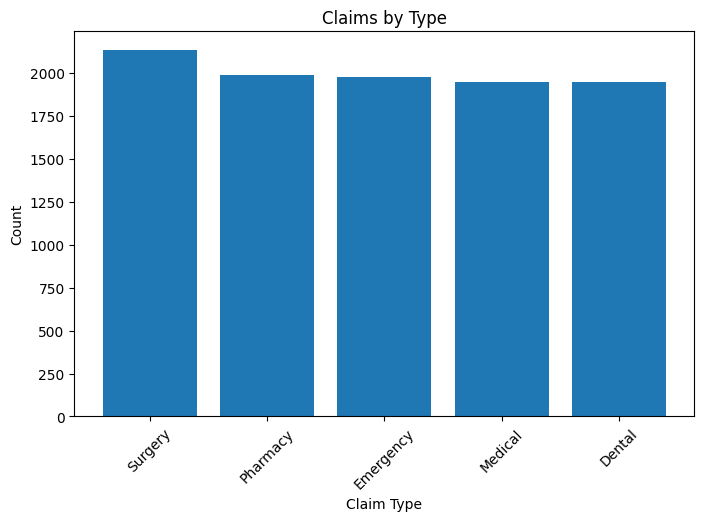

In [30]:
import matplotlib.pyplot as plt

counts = clean['claim_type'].value_counts()

plt.figure(figsize=(8,5))
plt.bar(counts.index, counts.values)
plt.xticks(rotation=45)
plt.title("Claims by Type")
plt.xlabel("Claim Type")
plt.ylabel("Count")
plt.show()


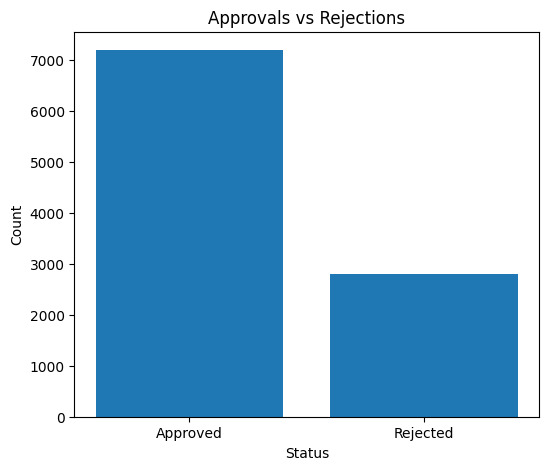

In [31]:
counts = clean['approval_status'].value_counts()

plt.figure(figsize=(6,5))
plt.bar(counts.index, counts.values)
plt.title("Approvals vs Rejections")
plt.xlabel("Status")
plt.ylabel("Count")
plt.show()


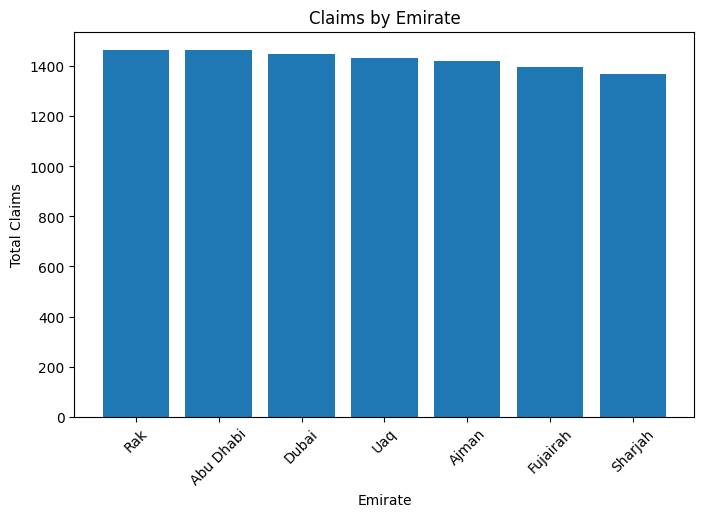

In [32]:
counts = clean['emirate'].value_counts()

plt.figure(figsize=(8,5))
plt.bar(counts.index, counts.values)
plt.xticks(rotation=45)
plt.title("Claims by Emirate")
plt.xlabel("Emirate")
plt.ylabel("Total Claims")
plt.show()


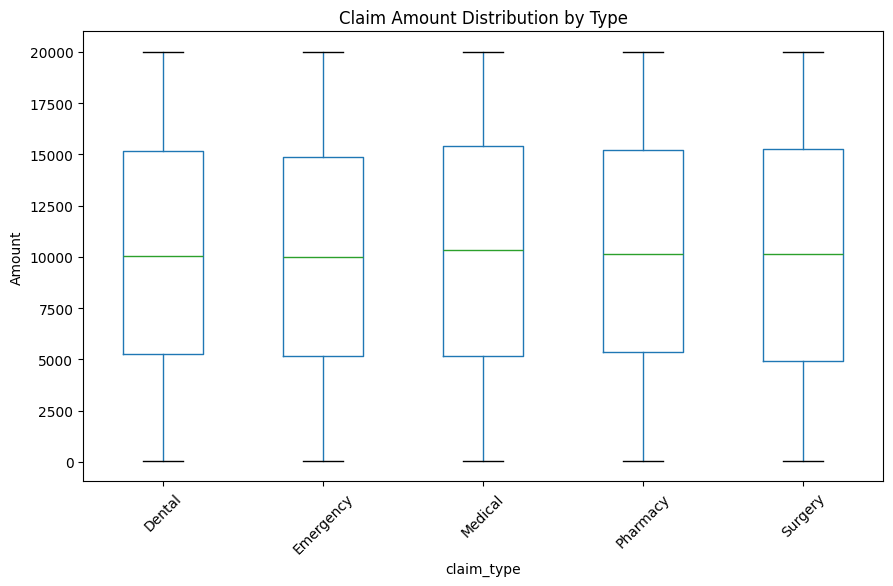

In [33]:
clean.boxplot(column="claim_amount", by="claim_type", figsize=(10,6), grid=False)
plt.xticks(rotation=45)
plt.title("Claim Amount Distribution by Type")
plt.suptitle("")
plt.ylabel("Amount")
plt.show()


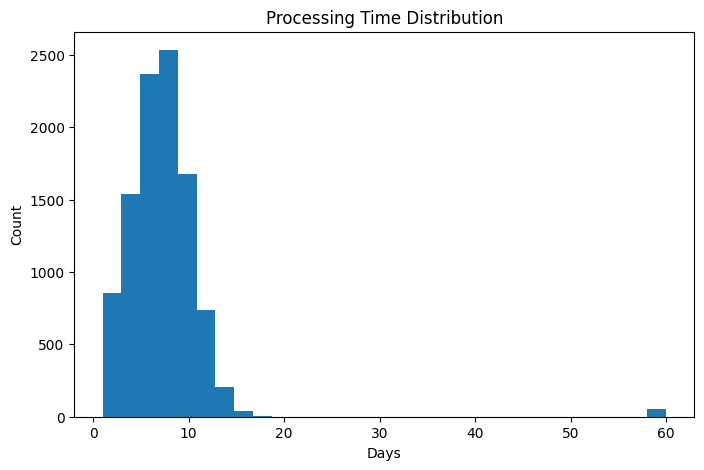

In [34]:
plt.figure(figsize=(8,5))
plt.hist(clean['processing_time_days'], bins=30)
plt.title("Processing Time Distribution")
plt.xlabel("Days")
plt.ylabel("Count")
plt.show()


In [39]:
# Export the clean DataFrame to CSV
clean.to_csv('claims_clean.csv', index=False)

# Optional: Display preview
print("First 5 rows of the clean data:")
print(clean.head())
print(f"\nCSV file created with {len(clean)} rows and {len(clean.columns)} columns")

# Download the CSV file to your local machine
from google.colab import files
files.download('claims_clean.csv')

First 5 rows of the clean data:
                               claim_id  claim_date  customer_age    emirate  \
0  54cacaba-5bb0-4c1f-9202-67f56e98b131  2025-06-28            56      Ajman   
1  b2e2241f-02cd-43fd-bd9f-14c2e04b883c  2025-02-01            69  Abu Dhabi   
2  5dd9160e-8a2c-4920-9190-4f4ee381217a  2025-11-18            46        Rak   
3  413d060a-ab94-4a06-b7a2-d8363afba27b  2025-11-02            32        Rak   
4  9e996e24-78a9-4d07-a66f-299f0932df9a  2025-06-17            60        Uaq   

   claim_amount claim_type    provider approval_status  rejection_reason  \
0       7776.46    Medical  Mediclinic        Approved    Not Applicable   
1      12024.04  Emergency       Aster        Approved    Not Applicable   
2      10297.37     Dental  Mediclinic        Approved    Not Applicable   
3      13906.11    Surgery       Aster        Approved    Not Applicable   
4       1156.90  Emergency  Mediclinic        Rejected  Incorrect Coding   

   processing_time_days amount

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>